# XGBoost Extended Best Model Corewise prediction
> Created Feb. 2025 <br>
> Nikhil Bisht<br>

In [21]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.json'
MCDSO_CORE = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_XGBoost_MCDS0_core.csv'
MCDSO_NONCORE = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_XGBoost_MCDS0_noncore.csv'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.80
NVALID_percentage =  0.05
NTEST_percentage  =  0.20

ALL_COLUMNS = ['Particle_id', 'Initial_Frame', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f']#, 'Vx_f', 'Vy_f', 'Vz_f', 'Density_f']
FEATURES = ALL_COLUMNS[1:9]
TARGET = ALL_COLUMNS[9:]

FRAMESTRAIN = np.arange(20,80, 1)
FRAMESTEST = np.arange(80,91, 1)
FRAMES = np.concatenate((FRAMESTRAIN, FRAMESTEST))
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

do_core = 1
if do_core == 1:
    df_timeseries = pd.read_csv(MCDSO_CORE)
    model_prefix = 'Core'
elif do_core == 0:
    df_timeseries = pd.read_csv(MCDSO_NONCORE)
    model_prefix = 'NonCore'
else:
    df_timeseries_core = pd.read_csv(MCDSO_CORE)
    df_timeseries_noncore = pd.read_csv(MCDSO_CORE)
    df_timeseries = pd.concat([df_timeseries_core, df_timeseries_noncore], axis=0)
    model_prefix = 'Combined'

#get core stuff
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    all_core_ids = tm['core_ids'][()]
    df_core_pids = tm['particle_ids'][()]

df_core_particles = pd.DataFrame({'Particle_id': df_core_pids, 'Core_id': all_core_ids})
df_timeseries_cored = pd.merge(df_timeseries, df_core_particles, on='Particle_id', how='outer')
df_timeseries_cored['Density_i'] = np.log10(df_timeseries_cored['Density_i'])
df_timeseries_cored

Available device: cpu 


,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Vx_i,Vy_i,Vz_i,Density_i,X_f,Y_f,Z_f,Core_id
0,1405,20,0.527180,0.158741,0.971439,6.421220,-1.876194,-5.372949,-0.556675,0.574790,0.162447,0.928789,229
1,1405,21,0.530244,0.157904,0.968864,6.398822,-1.615782,-5.381739,-0.537491,0.575226,0.162528,0.928519,229
2,1405,22,0.533308,0.157206,0.966303,6.432200,-1.313584,-5.327978,-0.600352,0.576575,0.162793,0.927728,229
3,1405,23,0.533990,0.157071,0.965739,6.447520,-1.237482,-5.316200,-0.604045,0.577861,0.163084,0.927018,229
4,1405,24,0.536361,0.156685,0.963763,6.136764,-0.782312,-5.301124,-0.612350,0.578874,0.163349,0.926462,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8215475,2096225,85,0.836629,0.295265,0.337399,2.948023,3.977006,-1.544051,1.042009,0.869000,0.342724,0.313928,197
8215476,2096225,86,0.838046,0.297183,0.336651,2.979185,4.046118,-1.583926,1.074655,0.870371,0.344821,0.312794,197
8215477,2096225,87,0.839227,0.298796,0.336021,3.002818,4.129562,-1.606884,1.125025,0.870486,0.344998,0.312699,197
8215478,2096225,88,0.839477,0.299141,0.335887,3.004597,4.146094,-1.610371,1.049079,0.871992,0.347339,0.311477,197


### Functions

In [22]:
def plot_prediction(y_true,y_pred, mae, r2, append=''):
    fig = plt.figure(figsize=(12, 4))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        ax.plot([0, 0], [1, 1], 'b-')
        ax.set_xlabel('True Values', fontsize=15)
        ax.set_ylabel('Predictions', fontsize=15)
        ax.set_title(f'{TARGET[i]}: MAE = {mae[i]:.6f}, R2 = {r2[i]:.4f}', fontsize=12)
        ax.set_ylabel(TARGET[i])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
    fig.tight_layout()
    plt.savefig('Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'_Prediction'+append+'.png')
    plt.show()

def df_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['del_X'] = df['X_f'] - df['X_i']
    df['del_Y'] = df['Y_f'] - df['Y_i']
    df['del_Z'] = df['Z_f'] - df['Z_i']
    df['X_op'] = np.where(np.abs(df['X_i'])<distance_condition, -1, +1)
    df['Y_op'] = np.where(np.abs(df['Y_i'])<distance_condition, -1, +1)
    df['Z_op'] = np.where(np.abs(df['Z_i'])<distance_condition, -1, +1)
    df['X_f'] = np.where(np.abs(df['del_X'])<distance_condition, df['X_f'], df['X_f']+df['X_op'])
    df['Y_f'] = np.where(np.abs(df['del_Y'])<distance_condition, df['Y_f'], df['Y_f']+df['Y_op'])
    df['Z_f'] = np.where(np.abs(df['del_Z'])<distance_condition, df['Z_f'], df['Z_f']+df['Z_op'])
    return df

def df_inverse_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['X_f'] = np.where(df['X_f']>=1, df['X_f']-1, df['X_f'])
    df['X_f'] = np.where(df['X_f']<0, df['X_f']+1, df['X_f'])
    df['Y_f'] = np.where(df['Y_f']>=1, df['Y_f']-1, df['Y_f'])
    df['Y_f'] = np.where(df['Y_f']<0, df['Y_f']+1, df['Y_f'])
    df['Z_f'] = np.where(df['Z_f']>=1, df['Z_f']-1, df['Z_f'])
    df['Z_f'] = np.where(df['Z_f']<0, df['Z_f']+1, df['Z_f'])
    return df


def model_test(model, test_df, distance_condition = 0.5):
    y_pred = model.predict(test_df[FEATURES])
    y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2]})
    y_pred_df =  df_inverse_transform(y_pred_df, distance_condition = distance_condition)
    
    return y_pred_df

## Split data

In [23]:
#Choose Training and Testing Cores

all_cores = np.unique(all_core_ids)
train_cores = np.random.choice(all_cores, int(NTRAIN_percentage*len(all_cores)), replace=False)
test_cores = np.setdiff1d(all_cores, train_cores)


df_timeseries_train = df_timeseries_cored[df_timeseries_cored['Core_id'].isin(train_cores)]
df_timeseries_test = df_timeseries_cored[df_timeseries_cored['Core_id'].isin(test_cores)]
df_timeseries_transformed = df_transform(df_timeseries_train)
X_train, y_train = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET]
X_test, y_test = df_timeseries_test[FEATURES], df_timeseries_test[TARGET]


## Train model Framewise
https://xgboost.readthedocs.io/en/stable/parameter.html

In [24]:
n_estimators    = [500, 800, 1500]  
max_depth       = [8 ,8, 8]
eta             = [0.1, 0.1, 0.01]
subsample       = [1, 1, 1]   
gamma           = [0.5, 0.5, 0.5]

#training only the best model
best_models = [0 ,0 ,0]
for i in range(1):
    best_models[i] = xgb.XGBRegressor(n_estimators=n_estimators[i], max_depth=max_depth[i], eta=eta[i], subsample=subsample[i], gamma = gamma[i], device = 'cpu')
    best_models[i].fit(X_train, y_train)
    best_models[i].save_model(model_prefix+"_Extended_Corewise_BestModel"+str(i)+"_"+MODELFILE)

print(len(X_train))

6644400


## Load Model

In [25]:
def mae_modded(y_true, y_pred):
    mae = np.array([0.,0.,0.])
    mae_diff = np.abs(y_true - y_pred)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    mae = stacked.min(axis=2).mean(axis=0)
    return mae

def r2_modded(y_true, y_pred):
    true_mean = np.mean(y_true,axis=0)
    mae_diff = np.abs(y_true - y_pred)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    r2_residual = stacked.min(axis=2)**2
    mae_diff = np.abs(y_true - true_mean)
    mae_add = 1 - mae_diff
    stacked = np.stack([mae_diff, mae_add], axis=2)
    r2_total = stacked.min(axis=2)**2

    return 1-r2_residual.sum(axis=0)/r2_total.sum(axis=0)

In [26]:
model_prefix

'Core'

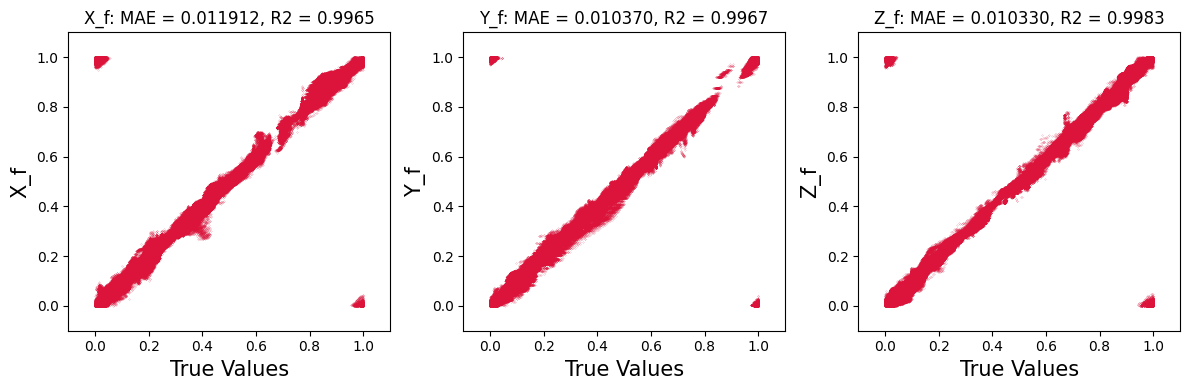

In [31]:
loaded_model = [0,0,0]
results_dic = {'Model_1_ypred':[], 'Model_2_ypred':[], 'Model_3_ypred':[], 'ytrue':y_test, 'test_df': df_timeseries_test}
for i in range(1):
    loaded_model[i] = xgb.XGBRegressor()
    loaded_model[i].load_model(model_prefix+"_Extended_Corewise_BestModel"+str(i)+"_"+MODELFILE)
    ypred, ytrue = model_test(loaded_model[i], X_test), y_test
    results_dic['Model_'+str(i+1)+'_ypred'] = ypred
    mae = mae_modded(ytrue.to_numpy(), ypred.to_numpy())
    r2 = r2_modded(ytrue.to_numpy(),ypred.to_numpy())
    plot_prediction(ytrue.to_numpy(),ypred.to_numpy(), mae, r2, append = "_"+model_prefix+"_Extended_Corewise_BestModel"+str(i))



In [32]:
import pickle
with open('/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_'+model_prefix+'_corewise_predictions.pickle', 'wb') as handle:
    pickle.dump(results_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [36]:
ypred

,X_f,Y_f,Z_f
0,0.584961,0.171172,0.952773
1,0.589440,0.173212,0.952527
2,0.593832,0.173927,0.952742
3,0.593832,0.173927,0.952742
4,0.583514,0.175539,0.953090
...,...,...,...
1571075,0.015085,0.993175,0.319390
1571076,0.011329,0.999493,0.321266
1571077,0.010813,0.007989,0.315904
1571078,0.010813,0.009527,0.315904


In [37]:
df_timeseries_test_with_pred = df_timeseries_test.copy()
df_timeseries_test_with_pred.reset_index(drop=True, inplace=True)
df_timeseries_test_with_pred['X_f_pred'] = ypred['X_f']
df_timeseries_test_with_pred['Y_f_pred'] = ypred['Y_f']
df_timeseries_test_with_pred['Z_f_pred'] = ypred['Z_f']
df_timeseries_test_with_pred

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,Vx_i,Vy_i,Vz_i,Density_i,X_f,Y_f,Z_f,Core_id,X_f_pred,Y_f_pred,Z_f_pred
0,1405,20,0.527180,0.158741,0.971439,6.421220,-1.876194,-5.372949,-0.556675,0.574790,0.162447,0.928789,229,0.584961,0.171172,0.952773
1,1405,21,0.530244,0.157904,0.968864,6.398822,-1.615782,-5.381739,-0.537491,0.575226,0.162528,0.928519,229,0.589440,0.173212,0.952527
2,1405,22,0.533308,0.157206,0.966303,6.432200,-1.313584,-5.327978,-0.600352,0.576575,0.162793,0.927728,229,0.593832,0.173927,0.952742
3,1405,23,0.533990,0.157071,0.965739,6.447520,-1.237482,-5.316200,-0.604045,0.577861,0.163084,0.927018,229,0.593832,0.173927,0.952742
4,1405,24,0.536361,0.156685,0.963763,6.136764,-0.782312,-5.301124,-0.612350,0.578874,0.163349,0.926462,229,0.583514,0.175539,0.953090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571075,2095654,85,0.974287,0.036167,0.378227,7.009280,-5.333251,-5.465914,0.706985,0.004375,0.010824,0.329586,105,0.015085,0.993175,0.319390
1571076,2095654,86,0.977352,0.033775,0.375548,5.820404,-4.741613,-5.660211,0.886924,0.005283,0.010100,0.327703,105,0.011329,0.999493,0.321266
1571077,2095654,87,0.979533,0.031974,0.373308,5.203026,-4.126725,-5.581395,0.756108,0.005362,0.010043,0.327546,105,0.010813,0.007989,0.315904
1571078,2095654,88,0.979962,0.031637,0.372842,5.036523,-3.916586,-5.548000,0.715205,0.006395,0.009327,0.325529,105,0.010813,0.009527,0.315904


In [54]:
df_timeseries_test_with_pred['Core_id'].unique()

array([229,  15,  59,  58, 203,  34,  96,  10, 106,  17, 238,  98,  23,
       134, 150, 148, 188, 105, 135, 191, 259, 252, 225, 220, 284, 262,
       230, 154, 157, 156,  91,  71, 171, 269, 129, 162,  40,  47,  48,
        39,  38, 183, 165,  65, 112, 235, 245, 115, 122, 164,  76, 120,
       264, 272, 127, 186,   7])